# Code Assignment 17 — K-Means Model Comparison with CH & DB + Assumption Testing (Mall Customers)

**Format:** Instructor Guidance → Your Task (step-by-step) → We Share (reflection)

**Goal:**  Compare **two feature sets** for K-Means at the **same K**:  
- **Model 1:** 2 features → `['Annual Income (k$)', 'Spending Score (1-100)']`  
- **Model 2:** 3 features → `['Age', 'Annual Income (k$)', 'Spending Score (1-100)']`  
Evaluate with **Silhouette (↑), Calinski–Harabasz (↑), Davies–Bouldin (↓)**, **separation ratio** (↑), **cluster sizes**, and **stability (median ARI) (↑)**.



## Instructor Guidance (Pseudocode + Docs)

**Docs**  
- `StandardScaler`: https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html  
- `KMeans`: https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html  
- `silhouette_score`: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html  
- `calinski_harabasz_score`: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.calinski_harabasz_score.html  
- `davies_bouldin_score`: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.davies_bouldin_score.html  
- `adjusted_rand_score` (stability): https://scikit-learn.org/stable/modules/generated/sklearn.metrics.adjusted_rand_score.html

### Pseudocode Plan (Model Comparison)
  1) Load CSV → pick clean numeric columns (2D vs 3D).  
  2) **Scale** each feature set **separately** with `StandardScaler`.  
  3) Fix **K** (e.g., K=4).  
  4) Fit KMeans on each set → get labels & centers.  
  5) Compute metrics: `silhouette_score` (↑), `calinski_harabasz_score` (↑), `davies_bouldin_score` (↓).  
  6) Assumption checks: **separation ratio** (min between-centroid distance ÷ max within-cluster spread), **cluster sizes** (%), **stability via ARI** across seeds.  
  7) Compare models in a table → pick one and justify.


## Your Task — Step-by-Step
Work in pairs. Keep it minimal and clear.

### 0) Run Helper Functions and do your Imports

In [18]:
import pandas as pd
import numpy as np
from pathlib import Path

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score, adjusted_rand_score
from scipy.spatial.distance import cdist

import matplotlib.pyplot as plt

pd.set_option('display.float_format', lambda x: f'{x:,.4f}')

In [19]:
# RUN THIS CELL WITHOUT CHANGES 

def cluster_size_pct(labels):
    """Return % size of each cluster (sorted by cluster index)."""
    s = pd.Series(labels).value_counts(normalize=True).sort_index()
    return (s * 100).round(1)

def within_between_ratio(Z, labels, centers):
    """
    Heuristic separation metric:
    min distance among centroids ÷ max within-cluster spread (avg feature std per cluster).
    Higher is better (more separated vs within spread).
    """
    within = []
    for c in range(centers.shape[0]):
        pts = Z[labels == c]
        if len(pts) == 0:
            within.append(np.nan)
        else:
            within.append(pts.std(axis=0).mean())
    within = np.array(within, dtype=float)
    max_within = np.nanmax(within)

    D = cdist(centers, centers)  # centroid distance matrix
    np.fill_diagonal(D, np.nan)
    min_between = np.nanmin(D)
    return float(min_between / max_within)

def stability_ari(Z, k, seeds=(0, 1, 2, 3, 4)):
    """
    Fit KMeans across multiple seeds and compute median Adjusted Rand Index across pairs.
    Higher median ARI = more stable clustering to initialization.
    """
    label_sets = []
    for s in seeds:
        km = KMeans(n_clusters=k, n_init=10, random_state=s).fit(Z)
        label_sets.append(km.labels_)
    pairs = [(i, j) for i in range(len(label_sets)) for j in range(i+1, len(label_sets))]
    aris = [adjusted_rand_score(label_sets[i], label_sets[j]) for (i, j) in pairs]
    return float(np.median(aris))


### 1) Load the Mall Customers CSV & Preview
Use the same dataset as last time.

In [20]:
df = pd.read_csv('/Users/gabriel/Desktop/marcy/DA2025_Lectures2/Mod6/data/Mall.csv', low_memory=False)
(df.shape, df.columns.tolist())

((200, 5),
 ['CustomerID',
  'Gender',
  'Age',
  'Annual Income (k$)',
  'Spending Score (1-100)'])

### 2) Build 2D and 3D feature sets (numeric only, minimal cleaning)

- 2D set:  Annual Income and Spending Score
- 3D set:  Age, Annual Income, Spending Score 

**Be sure to scale!**


In [26]:
scaler = StandardScaler()
# Minimal data cleaning
df = df.copy()
df = df.drop_duplicates()
df["Age"] = pd.to_numeric(df["Age"], errors="coerce")
df["Annual Income (k$)"] = pd.to_numeric(df["Annual Income (k$)"], errors="coerce")
df["Spending Score (1-100)"] = pd.to_numeric(df["Spending Score (1-100)"], errors="coerce")
df = df.dropna(subset=["Age", "Annual Income (k$)", "Spending Score (1-100)"])

# 2D feature set
X_2D = df[["Annual Income (k$)", "Spending Score (1-100)"]]
twodscale = scaler.fit_transform(X_2D)

# 3D feature set
X_3D = df[["Age", "Annual Income (k$)", "Spending Score (1-100)"]]
threedscale = scaler.fit_transform(X_3D)

print(X_2D.head())
print(X_3D.head())

   Annual Income (k$)  Spending Score (1-100)
0                  15                      39
1                  15                      81
2                  16                       6
3                  16                      77
4                  17                      40
   Age  Annual Income (k$)  Spending Score (1-100)
0   19                  15                      39
1   21                  15                      81
2   20                  16                       6
3   23                  16                      77
4   31                  17                      40


### 3) Choose a single k for BOTH models (you can try 3, 4, 5, etc.)

In [22]:
K_FIXED = 4
print('Using K =', K_FIXED)

Using K = 4


### 4) Fit Model 1 (2D @ K) and compute metrics

- No train-test split needed 
- Use helper functions above to help calculate metrics!


In [31]:
sil, ch, db = [], [], []

km = KMeans(n_clusters=K_FIXED, n_init = 10, random_state=0).fit(twodscale)
labels = km.labels_

sil.append(silhouette_score(twodscale,labels))

ch.append(calinski_harabasz_score(twodscale, labels))

db.append(davies_bouldin_score(twodscale, labels))

separation = within_between_ratio(twodscale,labels,km.cluster_centers_)

clustersize = cluster_size_pct(labels)
clustersizelist = pd.to_numeric(clustersize.values)

stability = stability_ari(twodscale, K_FIXED, seeds=(0, 1, 2, 3, 4))

allinfo = {'silhouette_score': sil,
           'calinski':ch,
           'davies':db,
           'separation ratio':separation,
           'clustersize':clustersize.to_string(),
           'stability':stability}

info = pd.DataFrame(data= allinfo)

info

,silhouette_score,calinski,davies,separation ratio,clustersize,stability
0,0.4939,174.5952,0.7096,2.9334,0 50.0000\n1 19.5000\n2 19.0000\n3 11....,1.0000


### 5) Fit Model 2 (3D @ K) and compute metrics

- No train-test split needed 
- Use helper functions above to help calculate metrics!
- Use same k as Model 1

In [32]:
sil2, ch2, db2 = [], [], []

km2 = KMeans(n_clusters=K_FIXED, n_init = 10, random_state=0).fit(threedscale)
labels2 = km2.labels_

sil2.append(silhouette_score(threedscale,labels2))

ch2.append(calinski_harabasz_score(threedscale, labels2))

db2.append(davies_bouldin_score(threedscale, labels2))

separation2 = within_between_ratio(threedscale,labels2,km2.cluster_centers_)

clustersize2 = cluster_size_pct(labels2)
clustersizelist2 = pd.to_numeric(clustersize2.values)

stability2 = stability_ari(threedscale, K_FIXED, seeds=(0, 1, 2, 3, 4))

allinfo2 = {'silhouette_score': sil2,
           'calinski':ch2,
           'davies':db2,
           'separation ratio':separation2,
           'clustersize':clustersize2.to_string(),
           'stability':stability2}

info2 = pd.DataFrame(data= allinfo2)

info2

,silhouette_score,calinski,davies,separation ratio,clustersize,stability
0,0.4040,125.6764,0.9308,3.1974,0 19.0000\n1 28.5000\n2 32.5000\n3 20....,1.0000


### 6) Visualize Model 1 (2D Scatter Plot)


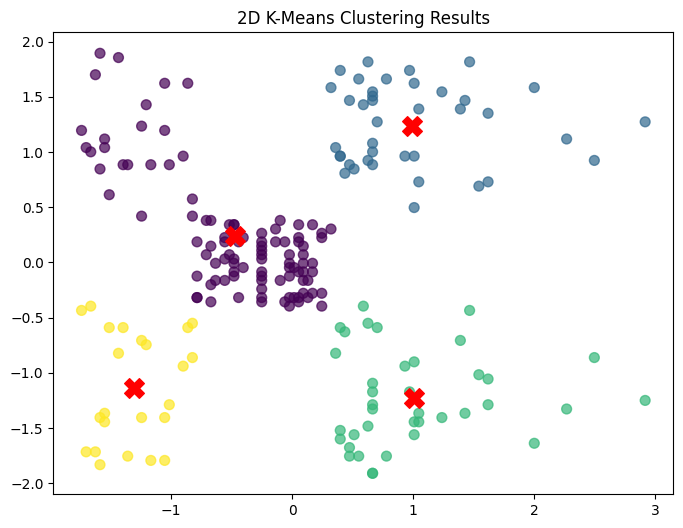

In [33]:
# Visualize the clusters
plt.figure(figsize=(8, 6))
plt.scatter(twodscale[:, 0], twodscale[:, 1], c=labels, cmap='viridis', s=50, alpha=0.7)
plt.scatter(km.cluster_centers_[:, 0], km.cluster_centers_[:, 1], s=200, c='red', marker='X')
plt.title('2D K-Means Clustering Results')
plt.show()

## We Share — Reflection (short, specific)
1) **Which model is better and why?** Reference **Sil (↑), CH (↑), DB (↓)**, **separation ratio (↑)**, **stability ARI (↑)**, and **cluster sizes**.  

2) **Assumptions & ethics:** Did your chosen model show **non-overlapping, roughly spherical, similarly dense** clusters? If not, what risk could that pose to stakeholders (mis-targeted offers, unfair treatment)?  
3) **Next step:** If you had to ship this, what monitoring would you add (e.g., re-check metrics quarterly, watch for tiny cluster drift, re-scale after schema changes)?

> Tip: If metrics conflict (e.g., CH prefers K=6, DB prefers K=4), prefer **parsimonious K** with **clear separation**, **stable labels**, and **business actionability**.


(1)

The 2D model is the stronger option. Its silhouette score, Calinski–Harabasz index, and separation ratio are all higher, while its Davies–Bouldin index is lower than the 3D model. Together, these metrics indicate that the 2D model forms tighter, better separated clusters, making its structure more reliable.

(2)

The clusters in my model show slight overlap and aren’t perfectly compact, which means a few points could shift clusters if the model were rerun. This creates a risk of misclassifying certain customers, potentially leading to poorly targeted offers or uneven treatment across segments.

(3)

If this were deployed, I’d set up periodic monitoring especially after new data comes in because additional observations can alter cluster shapes and boundaries. I’d regularly re-evaluate the metrics to ensure cluster quality stays consistent over time.